In [86]:
from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc

import basicest as b
import chemprop_ish as c
import delfos as d
import imp

from joypy import joyplot

In [105]:
data = pd.read_csv('full_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
size = len(solute)
print(size)

3312


In [106]:
#sizes
sol_set = list(set(solute))
solv_set = list(set(solvent))
print('# of unique solutes: ', len(sol_set))
print('# of unique solvents: ', len(solv_set))

# of unique solutes:  2905
# of unique solvents:  6


In [107]:
#solvent sizes
print('# of solutes in each solvent:')
for solv in solv_set:
    print(solv,':',solvent.count(solv))

# of solutes in each solvent:
C(CCl)Cl : 88
O : 2609
CS(=O)C : 130
CC#N : 400
CN(C)C=O : 20
C1CCOC1 : 65


<Figure size 432x288 with 0 Axes>

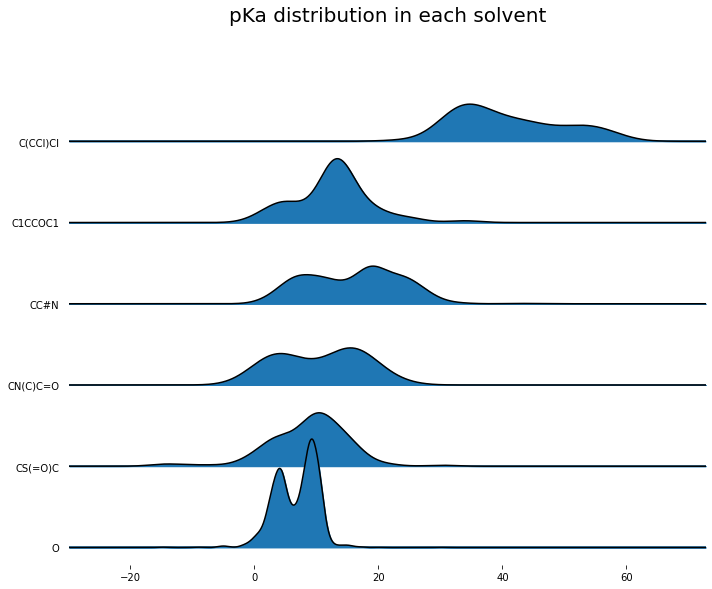

In [108]:
#pka spread in solvents
plt.figure()

joyplot(
    data=data[['pKa (avg)', 'Solvent SMILES']], 
    by='Solvent SMILES',
    figsize = (10,8)
)
plt.title('pKa distribution in each solvent', fontsize=20)
plt.show()

In [109]:
patt_list = [('any carbon','[#6]'),
             ('any nitrogen','[#7]'),
             ('any oxygen','[#8]'),
             ('any fluorine','[#9]'),
             ('any phosphorus','[#15]'),
             ('any sulfur','[#16]'),
             ('any chlorine','[#17]'),
             ('any bromine', '[#35]'),
             ('any iodine','[#53]'),
             ('any halide','[#6][F,Cl,Br,I]')]
matches = ddict(list)
for name, smart in patt_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        if mol.HasSubstructMatch(patt):
            matches[name].append(smile)
    print(name+' matches: '+str(len(matches[name])))

any carbon matches: 2896
any nitrogen matches: 2284
any oxygen matches: 1990
any fluorine matches: 342
any phosphorus matches: 49
any sulfur matches: 463
any chlorine matches: 398
any bromine matches: 105
any iodine matches: 26
any halide matches: 822


In [110]:
patt_list = [('H donor','[N,n,O;!H0]'),
             ('protonated amine','[NH+,NH2+,NH3+,nH+,nH2+]'),
             ('carboxylic acid','[CX3](=O)[OX2H1]'),
             ('amide','[NX3][CX3](=[OX1])[#6]'),
             ('aldehyde','[CX3H1](=O)[#6]'),
             ('amidinium','[NX3][CX3]=[NX3+]'),
             ('carbamate','[NX3,NX4+][CX3](=[OX1])[OX2,OX1-]'),
             ('carbamic ester','[NX3][CX3](=[OX1])[OX2H0]'),
             ('carbamic acid','[NX3,NX4+][CX3](=[OX1])[OX2H,OX1-]'),
             ('cyanamide','[NX3][CX2]#[NX1]'),
             ('ketone','[#6][CX3](=O)[#6]'),
             ('ether','[OD2]([#6])[#6]'),
             ('H+','[+H,+H2,+H3]'),
             ('amine','[NX3;H2,H1;!$(NC=O)]'),
             ('imine','[CX3;$([C]([#6])[#6]),$([CH][#6])]=[NX2][#6]'),
             ('nitrate','[$([NX3](=[OX1])(=[OX1])O),$([NX3+]([OX1-])(=[OX1])O)]'),
             ('nitrile','[NX1]#[CX2]'),
             ('nitro','[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]'),
             ('hydroxyl','[OX2H]'),
             ('hydroxyl alcohol','[#6][OX2H]'),
             ('enol','[OX2H][#6X3]=[#6]'),
             ('phenol','[OX2H][cX3]:[c]'),
             ('phosphoric acid','[$(P(=[OX1])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)]),$([P+]([OX1-])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)])]'),
             ('sulfuric acid ester','[$([SX4](=O)(=O)(O)O),$([SX4+2]([O-])([O-])(O)O)]'),
             ('sulfenic acid','[#16X2][OX2H,OX1H0-]'),
             ('sulfamic acid','[$([#16X4]([NX3])(=[OX1])(=[OX1])[OX2H,OX1H0-]),$([#16X4+2]([NX3])([OX1-])([OX1-])[OX2H,OX1H0-])]'),]
matches = ddict(list)
for name, smart in patt_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        if mol.HasSubstructMatch(patt):
            matches[name].append(smile)
    print(name+' matches: '+str(len(matches[name])))

H donor matches: 2784
protonated amine matches: 1625
carboxylic acid matches: 514
amide matches: 193
aldehyde matches: 10
amidinium matches: 27
carbamate matches: 12
carbamic ester matches: 12
carbamic acid matches: 0
cyanamide matches: 2
ketone matches: 80
ether matches: 541
H+ matches: 1625
amine matches: 341
imine matches: 3
nitrate matches: 2
nitrile matches: 135
nitro matches: 276
hydroxyl matches: 1249
hydroxyl alcohol matches: 1185
enol matches: 9
phenol matches: 462
phosphoric acid matches: 12
sulfuric acid ester matches: 1
sulfenic acid matches: 0
sulfamic acid matches: 0


In [111]:
patt_list = [('aromatic carbon','[$([cX3](:*):*),$([cX2+](:*):*)]')]
matches = ddict(list)
for name, smart in patt_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        if mol.HasSubstructMatch(patt):
            matches[name].append(smile)
    print(name+' matches: '+str(len(matches[name])))

aromatic carbon matches: 2213


In [98]:
featuriser = dc.feat.RDKitDescriptors()
sol = featuriser.featurize('CC')
featuriser.descriptors

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_V

In [99]:
rdkit_list = ['HeavyAtomCount',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'RingCount',
 'MolLogP',
 'MolMR',
 'fr_Al_COO',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_ArN',
 'fr_Ar_COO',
 'fr_Ar_N',
 'fr_Ar_NH',
 'fr_Ar_OH',
 'fr_COO',
 'fr_COO2',
 'fr_C_O',
 'fr_C_O_noCOO',
 'fr_C_S',
 'fr_HOCCN',
 'fr_Imine',
 'fr_NH0',
 'fr_NH1',
 'fr_NH2',
 'fr_N_O',
 'fr_Ndealkylation1',
 'fr_Ndealkylation2',
 'fr_Nhpyrrole',
 'fr_SH',
 'fr_aldehyde',
 'fr_alkyl_carbamate',
 'fr_alkyl_halide',
 'fr_allylic_oxid',
 'fr_amide',
 'fr_amidine',
 'fr_aniline',
 'fr_aryl_methyl',
 'fr_azide',
 'fr_azo',
 'fr_barbitur',
 'fr_benzene',
 'fr_benzodiazepine',
 'fr_bicyclic',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_epoxide',
 'fr_ester',
 'fr_ether',
 'fr_furan',
 'fr_guanido',
 'fr_halogen',
 'fr_hdrzine',
 'fr_hdrzone',
 'fr_imidazole',
 'fr_imide',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_ketone',
 'fr_ketone_Topliss',
 'fr_lactam',
 'fr_lactone',
 'fr_methoxy',
 'fr_morpholine',
 'fr_nitrile',
 'fr_nitro',
 'fr_nitro_arom',
 'fr_nitro_arom_nonortho',
 'fr_nitroso',
 'fr_oxazole',
 'fr_oxime',
 'fr_para_hydroxylation',
 'fr_phenol',
 'fr_phenol_noOrthoHbond',
 'fr_phos_acid',
 'fr_phos_ester',
 'fr_piperdine',
 'fr_piperzine',
 'fr_priamide',
 'fr_prisulfonamd',
 'fr_pyridine',
 'fr_quatN',
 'fr_sulfide',
 'fr_sulfonamd',
 'fr_sulfone',
 'fr_term_acetylene',
 'fr_tetrazole',
 'fr_thiazole',
 'fr_thiocyan',
 'fr_thiophene',
 'fr_unbrch_alkane',
 'fr_urea']

In [100]:
desc_list = []
from rdkit.Chem import Descriptors
for descriptor, function in Descriptors.descList:
    if descriptor in rdkit_list:
        desc_list.append((descriptor, function))

In [69]:
features = ddict(list)
for desc_name, function in desc_list:
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        feature = function(mol)
        features[desc_name].append(features)

sol_features = pd.DataFrame(features)
print(sol_features)

KeyboardInterrupt: 

In [101]:
featurizer = dc.feat.RDKitDescriptors()
sol_desc = featurizer.featurize(sol_set)

In [102]:
desc_list2 = featurizer.descriptors
[i for i,x in enumerate(desc_list2) if x == 'HeavyAtomCount']

[96]

In [103]:
sol_desc[0,300]

IndexError: index 300 is out of bounds for axis 1 with size 200

In [ ]:
features = ddict(list)
x = 96
for desc_name in desc_list2[96:]:
    for i in range(len(sol_set)):
        feature = sol_desc[i,x]
        features[desc_name].append(feature)
    x += 1

sol_features = pd.DataFrame(features)
print(sol_features)

In [ ]:
sol_features.to_csv('sol_features.csv')